100%|██████████| 170498071/170498071 [03:33<00:00, 798226.91it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Model with 10 parameters
Total number of parameters: 33428
Epoch 1/5, Train Loss: 1.8999, Train Accuracy: 0.3067, Test Loss: 1.8134, Test Accuracy: 0.3429
Epoch 2/5, Train Loss: 1.7942, Train Accuracy: 0.3478, Test Loss: 1.7581, Test Accuracy: 0.3605
Epoch 3/5, Train Loss: 1.7604, Train Accuracy: 0.3609, Test Loss: 1.7465, Test Accuracy: 0.3655
Epoch 4/5, Train Loss: 1.7432, Train Accuracy: 0.3645, Test Loss: 1.7233, Test Accuracy: 0.3723
Epoch 5/5, Train Loss: 1.7277, Train Accuracy: 0.3751, Test Loss: 1.7115, Test Accuracy: 0.3813
Model with 50 parameters
Total number of parameters: 161468
Epoch 1/5, Train Loss: 1.8198, Train Accuracy: 0.3380, Test Loss: 1.6983, Test Accuracy: 0.3846
Epoch 2/5, Train Loss: 1.6818, Train Accuracy: 0.3961, Test Loss: 1.6260, Test Accuracy: 0.4115
Epoch 3/5, Train Loss: 1.6277, Train Accuracy: 0.4138, Test Loss: 1.5872, Test Accuracy: 0.4307
Epoch 4/5, Train Loss: 1

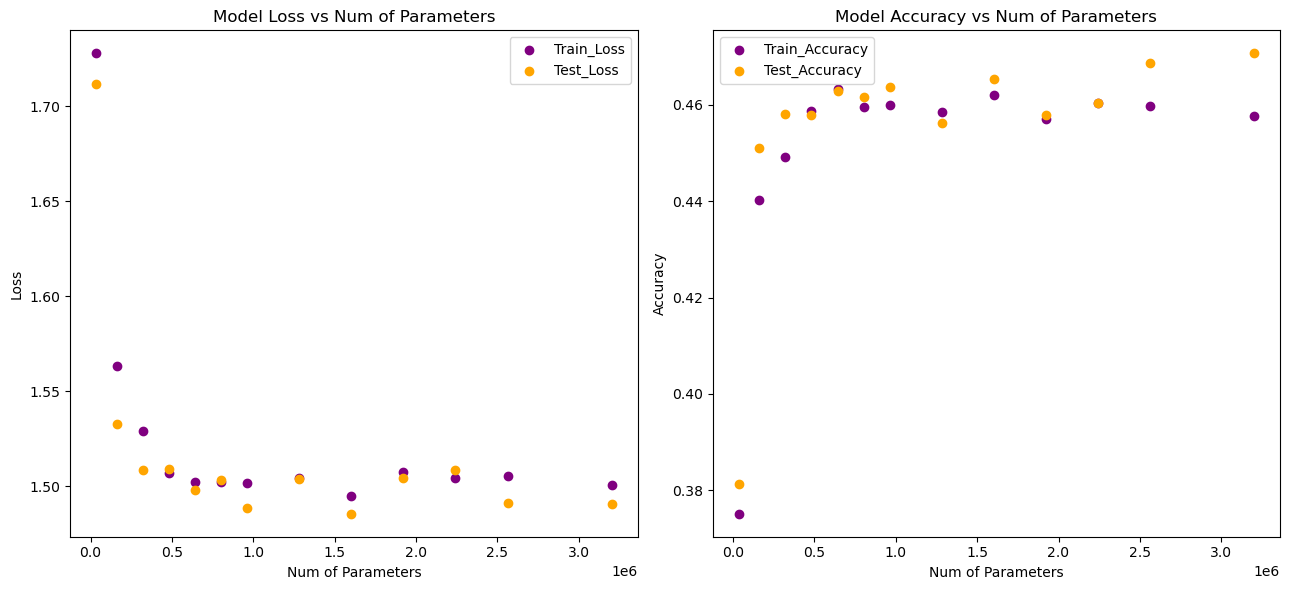

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
transform_data = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomCrop(32, padding=4),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_data)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_data)

train_data_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define a flexible DNN model, where the number of parameters can vary
class FlexibleNN(nn.Module):
    def __init__(self, param_count):
        super(FlexibleNN, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, param_count)  # CIFAR-10 has 32x32 images with 3 color channels
        self.layer2 = nn.Linear(param_count, 128)
        self.layer3 = nn.Linear(128, 10)  # Output for 10 classes in CIFAR-10

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input image
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

# Function to count the total number of parameters
def get_total_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Function to train and evaluate the model
def train_and_evaluate(net, train_loader, test_loader, optimizer, loss_function, total_epochs=5):
    train_loss_values = []
    test_loss_values = []
    train_acc_values = []
    test_acc_values = []

    for epoch in range(total_epochs):
        # Training phase
        net.train()
        total_train_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            predictions = net(inputs)
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * inputs.size(0)

            _, pred_classes = torch.max(predictions, 1)
            correct_train_preds += (pred_classes == labels).sum().item()
            total_train_samples += labels.size(0)

        train_loss_values.append(total_train_loss / len(train_loader.dataset))
        train_acc_values.append(correct_train_preds / total_train_samples)

        # Testing phase
        net.eval()
        total_test_loss = 0.0
        correct_test_preds = 0
        total_test_samples = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                predictions = net(inputs)
                loss = loss_function(predictions, labels)
                total_test_loss += loss.item() * inputs.size(0)

                _, pred_classes = torch.max(predictions, 1)
                correct_test_preds += (pred_classes == labels).sum().item()
                total_test_samples += labels.size(0)

        test_loss_values.append(total_test_loss / len(test_loader.dataset))
        test_acc_values.append(correct_test_preds / total_test_samples)

        print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss_values[-1]:.4f}, Train Accuracy: {train_acc_values[-1]:.4f}, Test Loss: {test_loss_values[-1]:.4f}, Test Accuracy: {test_acc_values[-1]:.4f}")

    return train_loss_values, test_loss_values, train_acc_values, test_acc_values

# List of different parameter counts to test
param_counts = [10, 50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 1000]

# To store results
train_loss_all = []
test_loss_all = []
train_acc_all = []
test_acc_all = []
param_totals = []

# Loop through different models with varying parameter counts
for param_count in param_counts:
    model_instance = FlexibleNN(param_count)
    optimizer = optim.Adam(model_instance.parameters(), lr=1e-3)
    loss_func = nn.CrossEntropyLoss()

    print(f"Model with {param_count} parameters")
    print(f"Total number of parameters: {get_total_params(model_instance)}")

    param_totals.append(get_total_params(model_instance))

    train_loss, test_loss, train_acc, test_acc = train_and_evaluate(model_instance, train_data_loader, test_data_loader, optimizer, loss_func)
    
    train_loss_all.append(train_loss[-1])
    test_loss_all.append(test_loss[-1])
    train_acc_all.append(train_acc[-1])
    test_acc_all.append(test_acc[-1])

# Plot Loss vs Number of Parameters
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.scatter(param_totals, train_loss_all, color='purple', label='Train_Loss')
plt.scatter(param_totals, test_loss_all, color='orange', label='Test_Loss')
plt.xlabel('Num of Parameters')
plt.ylabel('Loss')
plt.title('Model Loss vs Num of Parameters')
plt.legend()

# Plot Accuracy vs Number of Parameters
plt.subplot(1, 2, 2)
plt.scatter(param_totals, train_acc_all, color='purple', label='Train_Accuracy')
plt.scatter(param_totals, test_acc_all, color='orange', label='Test_Accuracy')
plt.xlabel('Num of Parameters')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Num of Parameters')
plt.legend()

plt.tight_layout()
plt.show()
